# WeRateDogs - Data Analysis

*Greg Clunies*<br>
*06/16/2018*

## Introduction & Background

This report presents analysis of data related to the [WeRateDogs](https://twitter.com/dog_rates) Twitter account. Data for this analysis was wrangled from three sources, which are described in `wrangle_report.html`.


In [73]:
# setup required packages
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import os
import json
import tweepy

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
# Cleanup output of pandas dataframe for easier exploration
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [114]:
# Load the previously wrangled, clean dataset
df_master = pd.read_csv('twitter_archive_master.csv')

In [76]:
# Set data types for use in analysis
df_master['tweet_id'] = df_master['tweet_id'].astype(str)
df_master['timestamp'] = pd.to_datetime(df_master['timestamp'])
df_master['dog_type'] = df_master['dog_type'].astype('category')

## Analysis

WeRateDogs often identifies dogs based on the various stages of their journery through life. Starting with the pupper, then puppo, and finally doggo. Floofer seems to be a term that transsends all three stages (i.e., all dogs are floofers). 

Let's see who gets the most mentions in tweets.

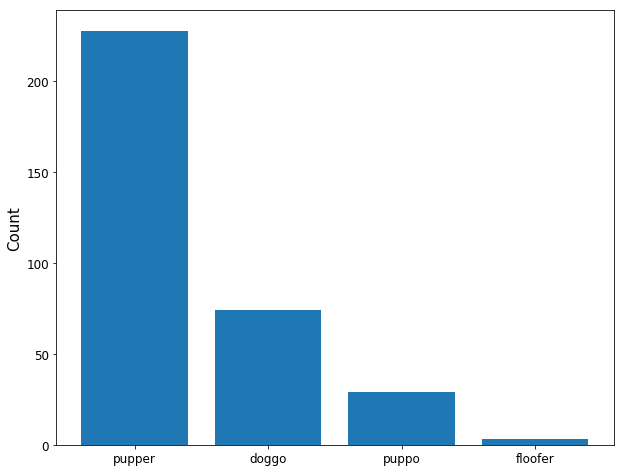

In [77]:
fig, ax = plt.subplots(figsize = (10, 8) )

ax.bar(df_master['dog_type'].value_counts().index, df_master['dog_type'].value_counts())
ax.set_ylabel('Count', fontsize = 15)
ax.tick_params(labelsize=12)

Of the tweets that included a dog type (334 of the 2045 tweets in `twitter_archive_master.csv`), puppers had the most mentions in tweets, with floofer having the least. A descrition of dog type terms used by WeRateDogs is provided in the [Dogtoinary](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png).

![dogtionary](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59e04ceb_dogtionary-combined/dogtionary-combined.png)

In addition to dog types, tweets from WeRateDogs often also included a rating (often greater that 10/10). I wonder if ratings change based on dog type? Are all dogs rated equal?

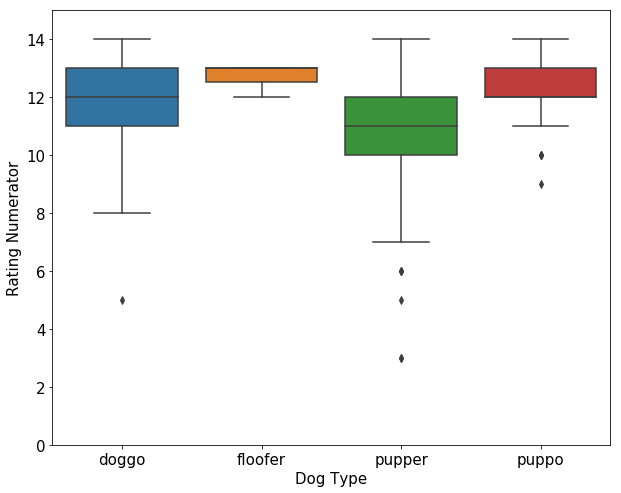

In [78]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 8))

sns.boxplot(x='dog_type', y='rating_numerator', data=df_master)
ax.set_ylim(0,15)
ax.set_ylabel('Rating Numerator', fontsize=15)
ax.set_xlabel('Dog Type', fontsize=15)
plt.tick_params(labelsize=15)

In [79]:
df_master['rating_numerator'].groupby(df_master['dog_type']).median()

dog_type
doggo      12
floofer    13
pupper     11
puppo      12
Name: rating_numerator, dtype: int64

The boxplot above shows us that the median rating for each dog-type is fairly similar, ranging from 11/10 (pupper) to 13/10 (floofer). Puppo and doggo types both have a median rating of 12/10. It seems that in general, all dogs get their fair share of praise.

**Note:** Occasionally, the denominator of a rating is not 10, but this comprises an almost neglible amount of the dataset (<1%).

In [80]:
p_not10 = sum(df_master['rating_denominator'].value_counts() != 10)/len(df_master)
print("% of ratings with denominator != 10 : " , round(p_not10*100,2), "%")

% of ratings with denominator != 10 :  0.68 %


But from the boxplot above, we also see some outliers that have low ratings. How could anyone provide such a rating to man's best friend?! We can get a better sense of the distribution of ratings for all tweets using a histogram.

Median rating numerator =  11.0




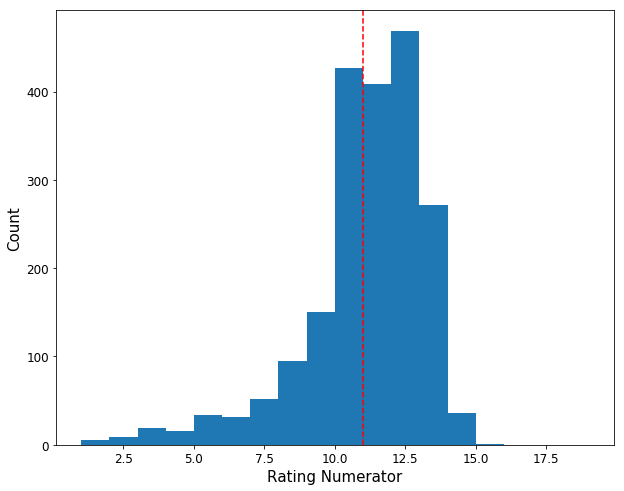

In [85]:
fig, ax = plt.subplots(figsize = (10, 8) )

ax.hist(df_master['rating_numerator'], bins = range(1,20))
ax.set_ylabel('Count', fontsize = 15)
ax.set_xlabel('Rating Numerator', fontsize = 15)
ax.tick_params(labelsize=12)
ax.axvline(df_master['rating_numerator'].median(), color='red', linestyle='--');

print('Median rating numerator = ', df_master['rating_numerator'].median())
print('\n')

This is a bit more insightful. We see that the median rating for all dogs (assuming a format of rating_numerator/10) is 11. Some dogs get higher ratings, but we clearly see that the distribution is left skewed with some dogs getting ratings less than 5! I wonder what those dogs did to deserve such a poor rating?

In [86]:
# get tweet_id for random tweet where rating is less than 5
df_master[df_master['rating_numerator'] <= 5].sample(1)['tweet_id']

2040    666049248165822465
Name: tweet_id, dtype: object

It turns out that these lower ratings are often the result of some humorous pictures/posts. For example, there is definitely something ***fishy*** going on for tweet_id [747816857231626240](https://twitter.com/dog_rates/status/747816857231626240). 

![bad_sherk](bad_sherk.PNG)

I think it's safe to say that this is the only 'sherk' breed that made it into our dataset. Speaking of breeds though, I wonder what the most popular dog breeds are on WeRateDogs?

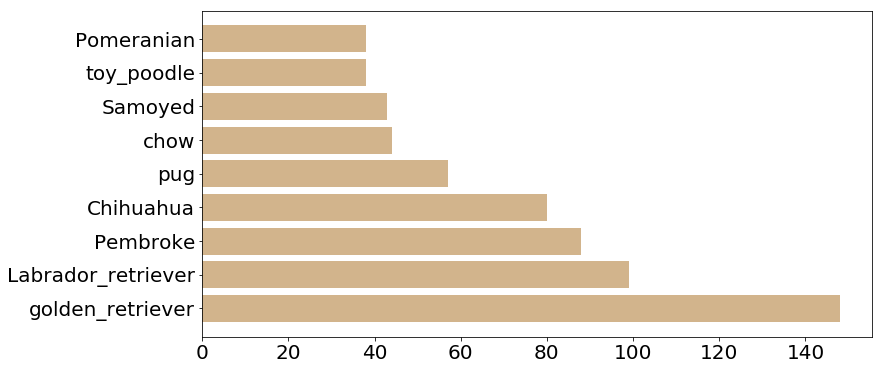

In [87]:
fig, ax = plt.subplots(figsize = (12, 6))

df_popular_dogs = df_master['p1'].value_counts()
df_popular_dogs = df_popular_dogs[df_popular_dogs > 30]

plt.barh(df_popular_dogs.index, df_popular_dogs, color = 'tan')
plt.tick_params(labelsize = 20)

In [108]:
# Get tweet URLs for 5 random goldens or labradors
tweet_ids = list(df_master[(df_master['p1'] == 'golden_retriever') | (df_master['p1'] == 'labrador_retriever')].sample(5).tweet_id)

base_url = 'https://twitter.com/dog_rates/status/'

tweet_urls = []

for tweet_id in tweet_ids:
    tweet_urls.append(base_url + tweet_id)
    
tweet_urls

['https://twitter.com/dog_rates/status/683098815881154561',
 'https://twitter.com/dog_rates/status/857029823797047296',
 'https://twitter.com/dog_rates/status/888917238123831296',
 'https://twitter.com/dog_rates/status/668979806671884288',
 'https://twitter.com/dog_rates/status/724983749226668032']

<br>Looks like Golden Retrievers and Labradors have the most representation on WeRateDogs. But based on the examples below, can you blame them? 

You can generate a list of tweet URLs for 5 random golden and labrador retrievers using the code block above to explore these popular breeds yourself. Each time you run the cell above you should get 5 new URLs (though repetition is theoretically possible).

![](golden.PNG)

![](lab.PNG)

As a wrap up of this brief analysis, now that we have some idea of the type, breed, and ratings for dogs on WeRateDogs, how is the Twitter account as a whole evolving. Is it getting more popular? We can begin to investigate by looking at the data as a timeseries.

In [110]:
# Use .resample() to get daily summmaries for daily total tweets, daily total retweets, and daily total favorites
daily_tweet_count = df_master.resample('D', on='timestamp').count()['timestamp']        # number of tweets made each day
daily_retweet_sum = df_master.resample('D', on='timestamp').sum()['retweet_count']      # total number of retweets by day
daily_favorite_sum = df_master.resample('D', on='timestamp').sum()['favorite_count']    # total number of favorites by day

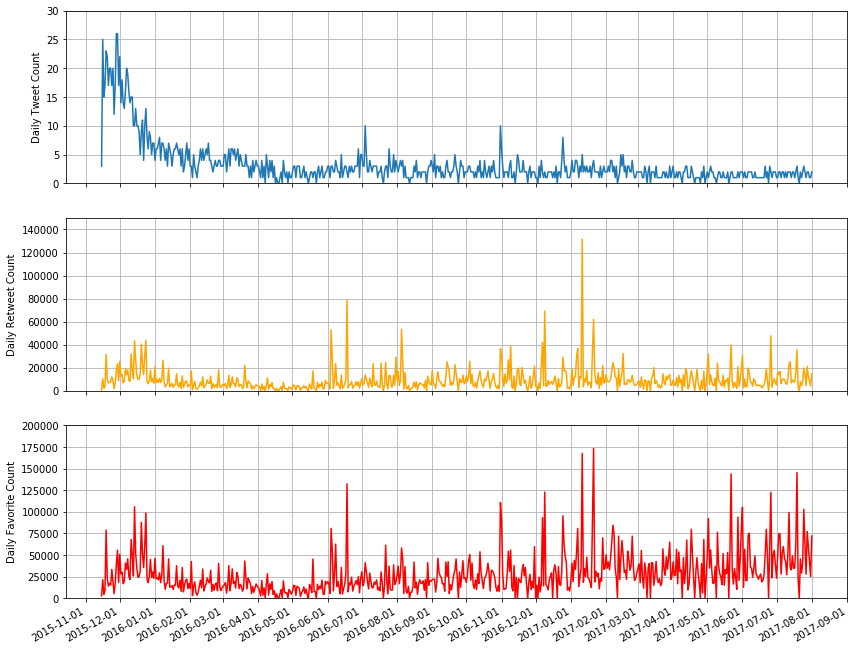

In [113]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (14,12) )

months = MonthLocator()  # every month
date_fmt = DateFormatter('%Y-%m-%d')

ax0.plot(daily_tweet_count.index, daily_tweet_count)
ax0.set_ylabel('Daily Tweet Count')
ax0.set_ylim(0,30)
ax0.xaxis.set_major_locator(months)
ax0.xaxis.set_major_formatter(date_fmt)
ax0.grid(which='both')

ax1.plot(daily_retweet_sum.index, daily_retweet_sum, 'orange')
ax1.set_ylabel('Daily Retweet Count')
ax1.set_ylim(0,150000)
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(date_fmt)
ax1.grid(which='both')

ax2.plot(daily_favorite_sum.index, daily_favorite_sum, 'red')
ax2.set_ylabel('Daily Favorite Count')
ax2.set_ylim(0,200000)
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(date_fmt)
ax2.grid(which='both')

fig.autofmt_xdate();

Interesting... it looks like the number daily tweets has decreased over time, with an initial surge of around 15-20 tweets a day for the first month or so (Novemeber to December, 2015). By 2017, daily activity is typicaly less than 5 tweets per day.

Both daily retweet count and daily favorite count show an initial bump during the first few months of the timeseries. This might be a result of WeRateDogs taking off on social media after it began in November 2015. We wactually see a reduction in daily retweets and favorite after the initial surge, but from time to time we see sharp spikes in both, often occuring in unison.

Although the number of dailiy tweets has decreased over time, we see that daily favorite count seem to be increasing. I think it's fair to say that this twitter account won't be seeing a major shift in this general trend anytime soon.

**Why?**

### **[BECAUSE THEY'RE GOOD DOGS BRENT!](http://knowyourmeme.com/memes/theyre-good-dogs-brent)**

